In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding

In [3]:
# df = pd.read_csv(r"C:\Users\smbm2\projects\research\csv_datasets\Scenario A1\TimeBasedFeatures-Dataset-15s-VPN.csv") # personal
df = pd.read_csv(r"C:\python\research\csv_datasets\Scenario A1\TimeBasedFeatures-Dataset-15s-VPN.csv") # for IR
df = df.drop(columns=['Unnamed: 0'])

le = LabelEncoder()
df['class1'] = le.fit_transform(df['class1'])

print(df['class1'].value_counts())
print(df.isna().any())

df.head()

1    9793
0    8965
Name: class1, dtype: int64
duration              False
total_fiat            False
total_biat            False
min_fiat              False
min_biat              False
max_fiat              False
max_biat              False
mean_fiat             False
mean_biat             False
flowPktsPerSecond     False
flowBytesPerSecond    False
min_flowiat           False
max_flowiat           False
mean_flowiat          False
std_flowiat           False
min_active            False
mean_active           False
max_active            False
std_active            False
min_idle              False
mean_idle             False
max_idle              False
std_idle              False
class1                False
dtype: bool


,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,...,267600.198443,1871488.0,1.983656e+06,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,0
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,...,221462.862028,1491627.0,3.572433e+06,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,0
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,...,217475.425246,1758922.0,1.758922e+06,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,0
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,...,436959.716436,1710925.0,2.382905e+06,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,0
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,...,436129.639296,1747431.0,2.400446e+06,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,0


In [4]:
class vpnDataset(Dataset):
    def __init__(self, df, target = 'class1'):
        self.n = df.shape[0]
        
        self.y = df[target].astype(np.float32).values

        self.x = df.drop(columns=[target]).astype(np.float32).values

    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [5]:
vpn_dataset = vpnDataset(df)
train_size = int(0.7*len(vpn_dataset))
print(train_size)
test_size = len(vpn_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(vpn_dataset, [train_size, test_size])
print(len(train_dataset), len(test_dataset))

13130
13130 5628


In [6]:
batch_sz = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_sz, shuffle=False)

### Preprocessing is Done. Model time.

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, key_len, self.heads, self.head_dim)
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        # if mask is not None:
        #     energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim)
        out = self.fc_out(out)
        return out
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()

        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class Encoder(nn.Module):
    def __init__(self,
                 sigma,
                 embed_size,
                 input_size,
                 n_features,
                 num_layers,
                 heads,
                 forward_expansion,
                 dropout
    ):
        super(Encoder, self).__init__()

        self.embed_size = embed_size
        self.embeddings = GaussianEncoding(sigma = sigma, input_size=input_size, encoded_size=embed_size//2) 
        
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion
                )
                for _ in range(num_layers)
            ]
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #(batch_size, n_features) -> (batch_size, n_features, 1)
        x = x.unsqueeze(2)
    
        x = self.embeddings(x) #(batch_size, n_features, emb_size)

        x = self.dropout(x)

        for layer in self.layers:
            #running embeddings through transformer block
            #keys, values, and query are all the same initially (x)
            x = layer(x, x, x)
     
        return x #same dimensions as going in 


In [8]:
class classificationHead(nn.Module):
    def __init__(self, n_features, embed_size, dropout):
        super(classificationHead, self).__init__()

        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.n_features = n_features*embed_size
        self.lin1 = nn.Linear(self.n_features, self.n_features//2)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(self.n_features//2, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin2.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin2.bias)

    def forward(self, x):
        x= torch.reshape(x, (-1, self.n_features))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.sigmoid(x)
  
        return x.squeeze(1)

In [9]:
class vpnClassifier(nn.Module):
    def __init__(self, 
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 n_features=23,
                 num_layers=2,
                 heads=4,
                 forward_expansion=4,
                 dropout=.5,
                 ):
        super(vpnClassifier, self).__init__()
        self.encoder = Encoder(sigma=sigma, embed_size=embed_size, input_size=input_size, n_features=n_features, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, dropout=dropout)
        self.classifying_head = classificationHead(n_features=n_features, embed_size=embed_size, dropout=dropout)
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifying_head(x)
        return x


In [10]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        # print(batch_idx, inputs, targets)
        pred = model(inputs)
        # print(pred)
        # print(pred.squeeze(0))
        loss = loss_fn(pred, targets)
        total_loss+= loss.item()

        # Calculate accuracy
        predicted_labels = (pred>0.5).float()
        # print(predicted_labels)
        total_correct += (predicted_labels == targets).sum().item()
        # print(total_correct)
        total_samples += targets.size(0)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy
    

def test(dataloader, model, loss_fn):
  model.eval()
  tot = 0
  total_correct = 0
  total_samples = 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(dataloader):
      #compute prediction error
      pred = model(inputs)
      test_loss = loss_fn(pred, targets)
      tot += test_loss

      # Calculate accuracy
      predicted_labels = (pred>0.5).float()
      # print(predicted_labels)
      total_correct += (predicted_labels == targets).sum().item()
      # print(total_correct)
      total_samples += targets.size(0)

  avg = tot/len(dataloader)
  accuracy = total_correct / total_samples

  return avg, accuracy

Epoch 1/15, Train Loss: 1.1780, Test Loss: 0.7473, Train Accuracy: 0.5073, Test Accuracy: 0.5464
Epoch 2/15, Train Loss: 1.1005, Test Loss: 0.7181, Train Accuracy: 0.5161, Test Accuracy: 0.5606
Epoch 3/15, Train Loss: 1.0319, Test Loss: 0.6970, Train Accuracy: 0.5196, Test Accuracy: 0.5698
Epoch 4/15, Train Loss: 0.9748, Test Loss: 0.6859, Train Accuracy: 0.5236, Test Accuracy: 0.5734
Epoch 5/15, Train Loss: 0.9380, Test Loss: 0.6727, Train Accuracy: 0.5174, Test Accuracy: 0.5743
Epoch 6/15, Train Loss: 0.8782, Test Loss: 0.6741, Train Accuracy: 0.5311, Test Accuracy: 0.5622
Epoch 7/15, Train Loss: 0.8417, Test Loss: 0.6694, Train Accuracy: 0.5322, Test Accuracy: 0.5640
Epoch 8/15, Train Loss: 0.8138, Test Loss: 0.6685, Train Accuracy: 0.5334, Test Accuracy: 0.5599
Epoch 9/15, Train Loss: 0.7864, Test Loss: 0.6658, Train Accuracy: 0.5379, Test Accuracy: 0.5625
Epoch 10/15, Train Loss: 0.7686, Test Loss: 0.6658, Train Accuracy: 0.5343, Test Accuracy: 0.5601
Epoch 11/15, Train Loss: 0.75

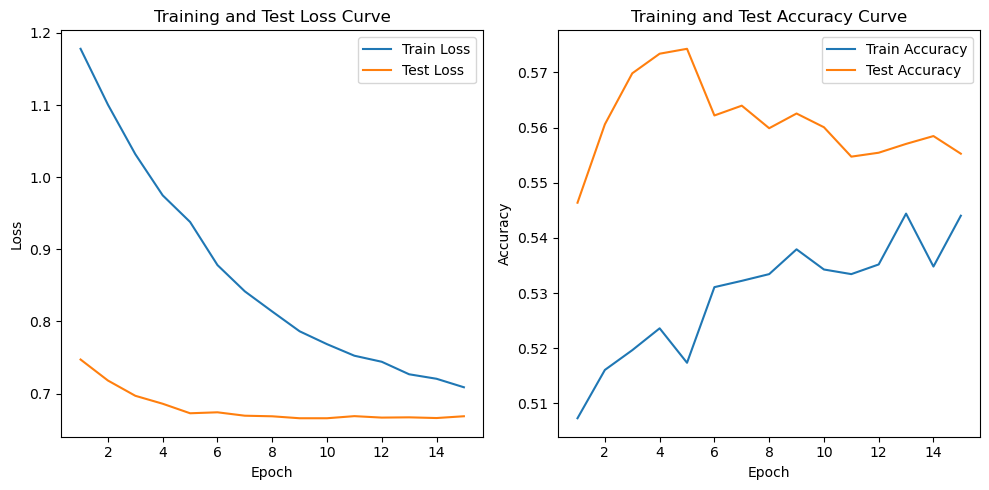

Best accuracy: 0.574271499644634


In [18]:
model = vpnClassifier(embed_size=30, num_layers=1, heads=10, dropout=0.5)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 15
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")